In [54]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys

In [4]:
suppl = Chem.SDMolSupplier("../data/drugbank.sdf")
drugbank = [m for m in suppl if m]

In [27]:
substructures = {
    'COO': Chem.MolFromSmarts('C(=O)O'),
    'benzene': Chem.MolFromSmarts('c1ccccc1'),
    'N': Chem.MolFromSmarts('[#7]'),
    'halogen': Chem.MolFromSmarts('[F,Cl,Br,I]'),
    'triple_bond': Chem.MolFromSmarts('*#*'),
    'aliphatic_c': Chem.MolFromSmarts('C'),
    'S': Chem.MolFromSmarts('S'),
    #'inorganic': Chem.MolFromSmarts('[[!#1];[!#6];[!#7];[!#8];[!#16];!F;!Cl;!Br;!I]'),
}
pattern_names = tuple(substructures.keys())
pattern_names

('COO', 'benzene', 'N', 'halogen', 'triple_bond', 'aliphatic_c', 'S')

In [10]:
def apply_substr_key(m, name_order, pattern_dict):
    return tuple((m.HasSubstructMatch(pattern_dict[name]) for name in name_order))

In [28]:
substructures.items()

dict_items([('COO', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee64800>), ('benzene', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee641c0>), ('N', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee648a0>), ('halogen', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee648f0>), ('triple_bond', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee64940>), ('aliphatic_c', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee64990>), ('S', <rdkit.Chem.rdchem.Mol object at 0x7fd98ee649e0>)])

In [31]:
apply_substr_key(drugbank[123], pattern_names, substructures)

(True, True, True, False, False, True, False)

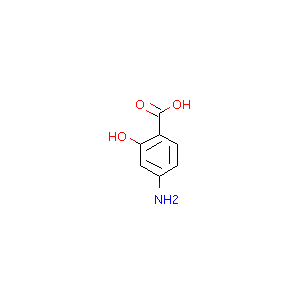

In [32]:
Draw.MolToImage(drugbank[123])

In [34]:
custom_struct_keys = [apply_substr_key(m, pattern_names, substructures) for m in drugbank]
len(custom_struct_keys)

7110

In [35]:
custom_struct_keys[:10]

[(True, True, True, False, False, True, False),
 (False, True, True, False, False, True, False),
 (False, True, True, False, False, True, True),
 (False, True, True, True, False, True, False),
 (False, False, True, False, False, True, False),
 (False, True, True, False, False, True, True),
 (False, True, True, False, False, True, True),
 (False, False, True, False, False, True, False),
 (False, True, True, False, True, True, False),
 (True, True, True, False, False, True, False)]

In [37]:
counts = list(map(sum, zip(*custom_struct_keys))) # black magic

In [38]:
counts

[2397, 4286, 5679, 1637, 246, 6830, 1355]

In [39]:
pattern_names

('COO', 'benzene', 'N', 'halogen', 'triple_bond', 'aliphatic_c', 'S')

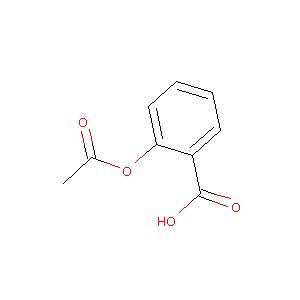

In [40]:
aspirin = Chem.MolFromSmiles('O=C(C)Oc1ccccc1C(=O)O')
Draw.MolToImage(aspirin)

In [41]:
aspirin_key = apply_substr_key(aspirin, pattern_names, substructures)
aspirin_key

(True, True, False, False, False, True, False)

In [47]:
aspirin_key_hits = [i for i, key in enumerate(custom_struct_keys) if key == aspirin_key]
len(aspirin_key_hits)

151

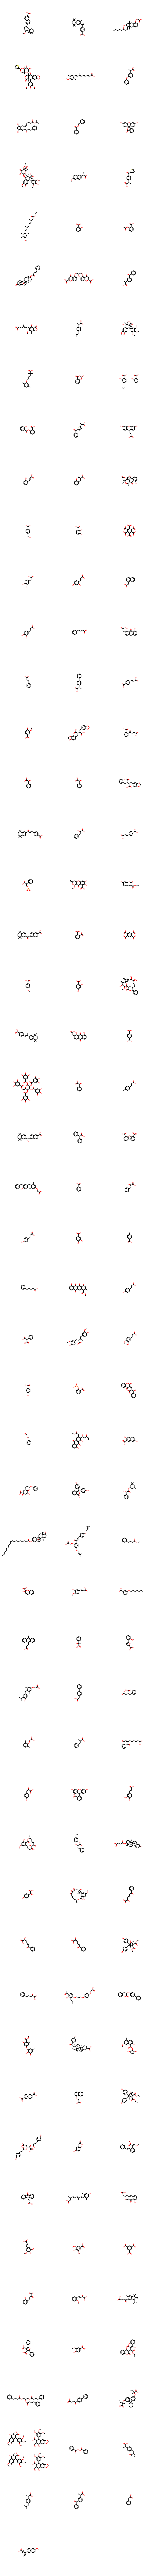

In [48]:
Draw.MolsToGridImage([drugbank[i] for i in aspirin_key_hits])

In [49]:
def potential_superstructure(super_key, query_key):
    for s, q in zip(super_key, query_key):
        if q and not s:
            return False
    return True

In [50]:
aspirin_potential_superstructures = [i for i, key in enumerate(custom_struct_keys)
                                     if potential_superstructure(key, aspirin_key)]
len(aspirin_potential_superstructures)

1322

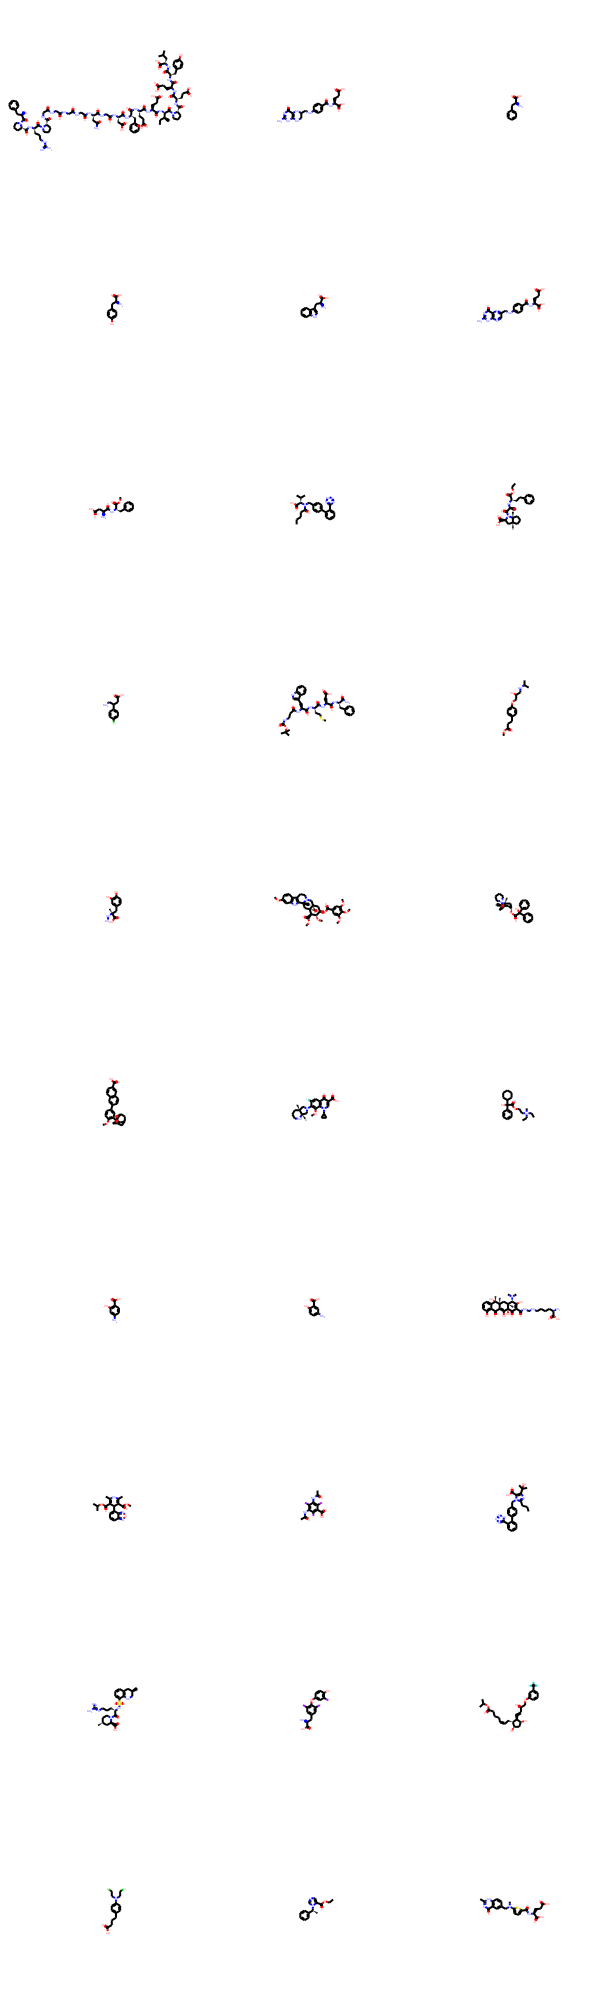

In [51]:
Draw.MolsToGridImage([drugbank[i] for i in aspirin_potential_superstructures[:30]])

In [56]:
drugbank_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugbank]

In [62]:
aspirin_maccs = MACCSkeys.GenMACCSKeys(aspirin)
tuple(aspirin_maccs.GetOnBits())

(89,
 113,
 123,
 126,
 127,
 136,
 139,
 140,
 143,
 144,
 146,
 150,
 152,
 154,
 157,
 159,
 160,
 162,
 163,
 164,
 165)

In [65]:
aspirin_maccs_hits = [i for i, key in enumerate(drugbank_maccs) if key == aspirin_maccs]
aspirin_maccs_hits

[824]

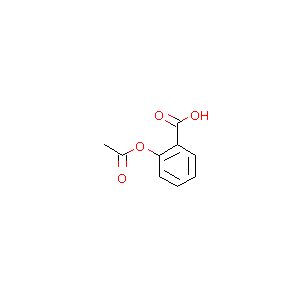

In [66]:
Draw.MolToImage(drugbank[824])

In [67]:
def potential_maccs_superstructure(super_key, query_key):
    for on_bit in query_key.GetOnBits(): # iterate all indexes of "True" bits on query key
        if not super_key.GetBit(on_bit): # if the "True" bit on query key isn't in the superstructure key ... read the documentation: http://www.rdkit.org/docs-beta/api/rdkit.DataStructs.cDataStructs.ExplicitBitVect-class.html
            return False # ... the superstructure key can't really be the superstructure
    return True # if all pass, it can be a superstructure

In [68]:
aspirin_potential_maccs_superstructures = [i for i, key in enumerate(drugbank_maccs)
                                            if potential_maccs_superstructure(key, aspirin_maccs)]
len(aspirin_potential_maccs_superstructures)

108

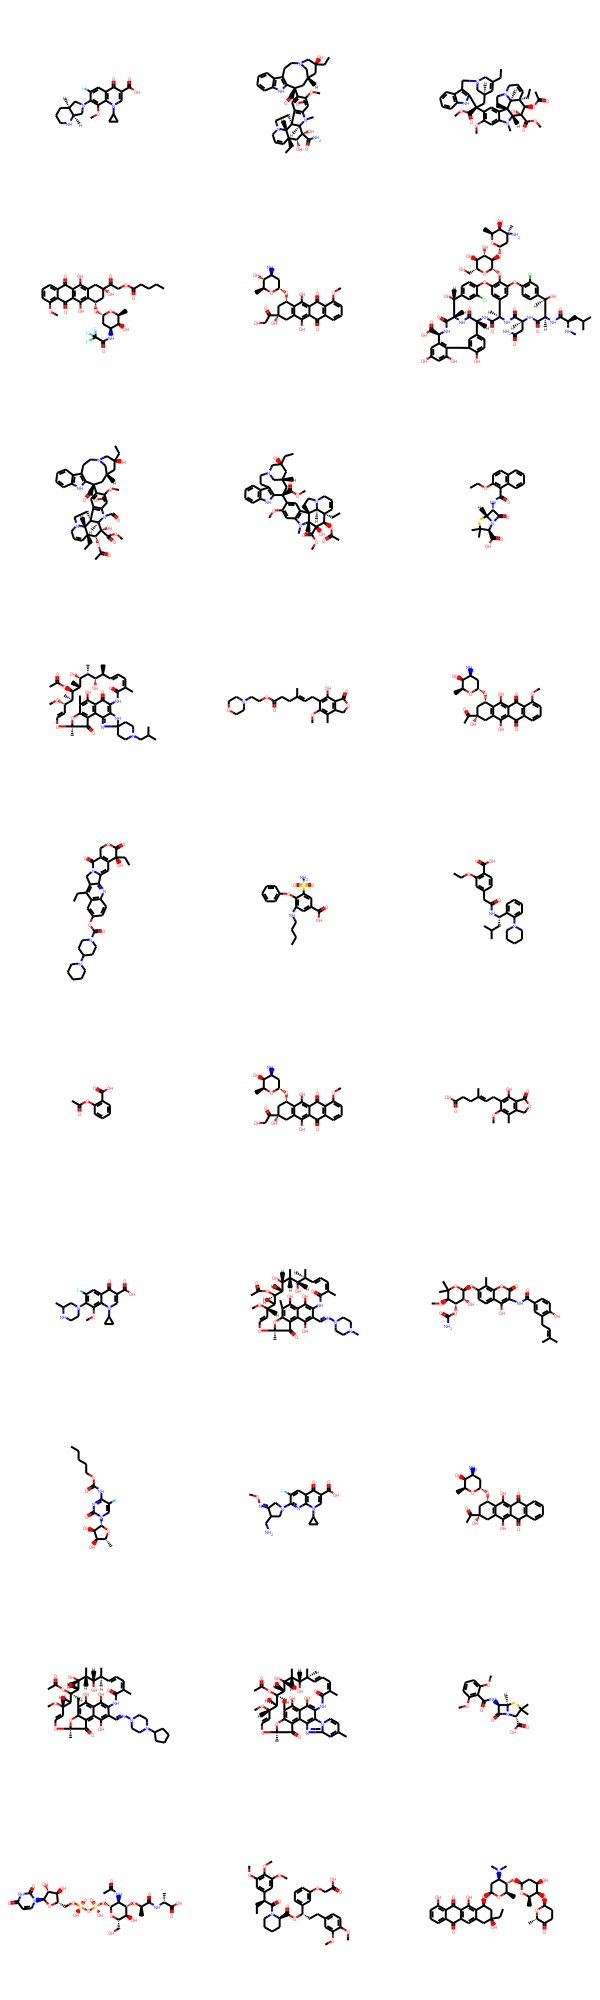

In [69]:
Draw.MolsToGridImage([drugbank[i] for i in aspirin_potential_maccs_superstructures[:30]])

In [86]:
import time
from rdkit.Chem.Draw import IPythonConsole

In [101]:
brut_start=time.time()
brut_struct = []
for mol in drugbank:
    if mol.HasSubstructMatch(aspirin):
        brut_struct.append(mol)
brut_end=time.time()

smart_start=time.time()
smart_struct = []
potential_superstructures = [i for i, key in enumerate(drugbank_maccs)
                                            if potential_maccs_superstructure(key, aspirin_maccs)]
for i in potential_superstructures:
    if drugbank[i].HasSubstructMatch(aspirin):
        smart_struct.append(drugbank[i])
smart_end=time.time()

In [102]:
print(len(brut_struct), len(smart_struct))
print(brut_end-brut_start, smart_end-smart_start)

3 2
0.12465405464172363 0.04207777976989746


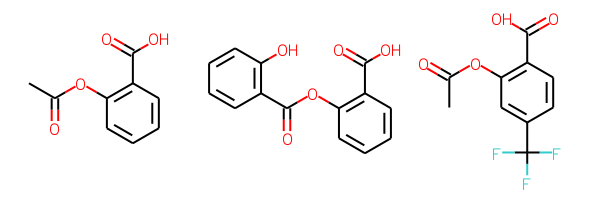

In [103]:
Draw.MolsToGridImage(brut_struct)

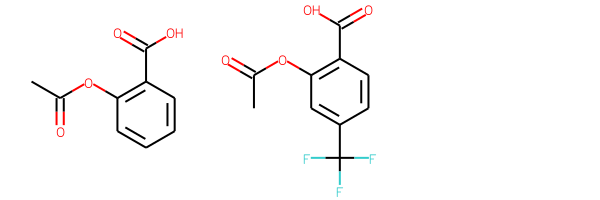

In [104]:
Draw.MolsToGridImage(smart_struct)